## Linear regresion on data for device id 249
Here I will try to find the function to fit the data and detect anomalies

In [1]:
import math
import pandas as pandas
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from statistics import mean
from numpy.random import shuffle

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

data_248 = pandas.read_json("../data/device_id_248.json")
data_249 = pandas.read_json("../data/device_id_249.json")

In [2]:
# Already prepared data from Intial data analysis - removed empty rows and wrong dates
data_248

,tot1,tot2,analog2
2018-12-11 12:10:00,116.15,0.00,0.82
2018-12-11 12:11:00,118.02,0.00,0.82
2018-12-11 12:12:00,119.90,0.00,0.82
2018-12-11 12:13:00,121.77,0.00,0.81
2018-12-11 12:14:00,123.64,0.00,0.82
...,...,...,...
2020-04-01 14:05:00,977428.25,-4713.21,1.54
2020-04-01 14:06:00,977428.88,-4713.21,1.54
2020-04-01 14:07:00,977429.50,-4713.21,1.54
2020-04-01 14:08:00,977430.12,-4713.21,1.54


Function generate data for a given timeframe

In [3]:
def draw_given_and_predicted(given, predicted):
    # takes in two arrays - 1. the actual data 2. predicted data
    fig = plt.figure(figsize=(8, 6), dpi= 100, facecolor='w')
    plt.plot(given, color="blue", label="Actual values")
    plt.plot(predicted, color="red", label="Predicted values")
    plt.legend(loc="upper left")
    plt.margins(0, 0.1)
    plt.xticks([])

    plt.ylabel('Pressure in bar')
    plt.xlabel('Cases')
    plt.title('Pressumer through time')
    plt.show()

In [4]:
def generate_day_view(start_date, end_date, data):
    print(start_date, end_date)
    start_day = start_date.strip() + " 00:00"
    end_day = end_date.strip() + " 23:59"
    data = data.loc[(data.index >= start_day) & (data.index <= end_day)]
    
    if len(data.index) < 1:
        raise Exception("No data for this date")
    
    # all values without pressure -> [:,:3], just pressure -> [:,3:]
    # TODO -> convert date to number format and try to find correlation ?
    data.index = pandas.to_datetime(data.index)
    matrix_X = data.reset_index().values

    size_of_learn_set = round(len(matrix_X) * 0.70)
    
    # Dividing data on the test and learn set
    learn_set = matrix_X[:size_of_learn_set]
    test_set  = matrix_X[size_of_learn_set:]
    
    model = LinearRegression()
    model.fit(learn_set[:,1:3], learn_set[:,3:])
    predicted_values = model.predict(test_set[:,1:3])
    
    accuracy = mean_squared_error(test_set[:,3:], predicted_values)
    draw_given_and_predicted(test_set[:,3:], predicted_values)
    
    return accuracy

2019-01-01 2020-04-01


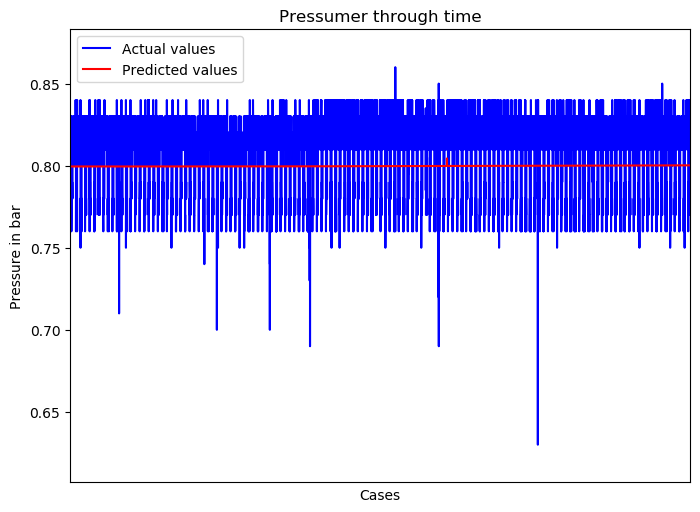

Values predicted on this time interval have an error of 0.0004442610319585364 .


In [5]:
# generate_day_view("2018-01-01", "2020-04-01", data_249)
# acc = generate_day_view(str(data_249.index[0]), str(data_249.index[-1]), data_249)
acc = generate_day_view("2019-01-01", "2020-04-01", data_249)
print("Values predicted on this time interval have an error of", acc, ".")

In [6]:
# Napovedana vrednost - aka tuki smo iskali oceno, na zacetku smo dali ocene vseh filmov in uporabnika, 
# pol smo pa dali uporabnika in ocene in je probalo napovedat

"""
Napovedat hocmo pritisk torej je pritisk to, napovedat ga hocmo na podlagi parametru [time, tot1, tot2]
- torej rabim za vsak pritisk matriko X [[time, tot1, tot2], [time, tot1, tot2], [time, tot1, tot2], ......]
- Y bodo pa pritiski [1.5, 1.5, 1.6, ....]
- za predictat pa vzamem spet matriko X -  [[time, tot1, tot2],... ] za en dan... -> vrne mi vrednosti
- to pol comparam z dejanskim pritiskom od takrat in zracunam razliko med napovedanim
""";

## Determining variable correlation
Here I will try to find if variables effect each other.

In [7]:
# 248
from scipy.stats import pearsonr

pearson_coef_tot1_248, p_value_tot1_248 = pearsonr(data_248["tot1"], data_248["analog2"]) 
pearson_coef_tot2_248, p_value_tot2_248 = pearsonr(data_248["tot2"], data_248["analog2"])

print("For device id 248")
print("Pearson Correlation Coefficient: {:.2f}".format(pearson_coef_tot1_248)) 
print("Pearson Correlation Coefficient: {:.2f}".format(pearson_coef_tot2_248))

For device id 248
Pearson Correlation Coefficient: 0.81
Pearson Correlation Coefficient: -0.28


In [8]:
# 249
pearson_coef_tot1_249, p_value_tot1_249 = pearsonr(data_249["tot1"], data_249["analog2"]) 
pearson_coef_tot2_249, p_value_tot2_249 = pearsonr(data_249["tot2"], data_249["analog2"])

print("For device id 249")
print("Pearson Correlation Coefficient: {:.2f}".format(pearson_coef_tot1_249)) 
print("Pearson Correlation Coefficient: {:.2f}".format(pearson_coef_tot2_249))

For device id 249
Pearson Correlation Coefficient: 0.14
Pearson Correlation Coefficient: -0.09


For device with id 249 we can draw a conclusion that variables "tot1" and "tot2" are not correlated(not strong enough) that we could take them into a count when building a regression model.   
But for device with id 248 there seems to be a strong correlation(0.81 coefficient) with "tot1" variable. This may be the case because the "analog2" column contains almost the same values for all data. So if we were to make a conclusion that "tot1" directly impacts "analog2" we would need data for atleast one more sensor.